In [1]:
# Import packages
import random
import numpy as np
import csv
import scipy.stats
import random

In [2]:
# Functions to select second and third elements in a list
def sel_second(x):
    return x[1]
def sel_third(x):
    return x[2]

In [3]:
# Function to normalize a vector
def normalize_vec(x):
    if np.sum(x**2)>0:
        normed_x = x / np.sqrt(np.sum(x**2))
    else:
        normed_x = x.copy()
    return normed_x

In [4]:
# Function to normalize all vectors in a matrix
def normalize_matrix(mat):
    sq_mat = mat**2
    sum_sq = np.sum(sq_mat, axis=1)
    mag = np.sqrt(sum_sq)
    mag[mag == 0] = 1
    normed_mat = np.transpose((np.transpose(mat) / mag))
    return normed_mat

The txt file for the MINERVA OPS word vectors can be found at our OSF page at https://osf.io/6mys9/

In [5]:
### Load word vectors

### Dimensions 0-500 -> Semantic features
### Dimensions 500-750 -> Phonological features
### Dimensions 750-1000 -> Orthographic features

with open('MINERVA OPS word vectors.txt', 'r') as f:
    df = f.readlines()
    word_matrix = []
    word_list = []
    for i in df:
        dataline = i.strip()
        dataline = dataline.split()
        word_list.append(dataline[0])
        word_matrix.append(np.array(dataline[1:], dtype=np.float32))

In [6]:
# create dictionary object to match words to rows in the word matrix
word_dic = {}
for i in range(0, len(word_list)):
    word_dic[word_list[i]] = i

In [7]:
# convert list to numpy matrix
word_matrix = np.array(word_matrix, dtype=np.float32)

In [8]:
# function to find a word's neighbors based on semantic, phonological, orthographic, or all features
def find_neighbors_by_space(word, word_dic, word_matrix, space='sem', n=30):
    if space == 'sem':
        target_word = word_matrix[word_dic[word]][:500]
        word_space = word_matrix[:, 0:500]
    elif space == 'phon':
        target_word = word_matrix[word_dic[word]][500:750]
        word_space = word_matrix[:, 500:750]
    elif space == 'ortho':
        target_word = word_matrix[word_dic[word]][750:]
        word_space = word_matrix[:, 750:]
    elif space == 'all':
        target_word = normalize_vec(word_matrix[word_dic[word]].copy())
        word_space = word_matrix
    word_space = normalize_matrix(word_space)
    word_list = [i for i in word_dic]
    cos_sim = normalize_vec(target_word) @ np.transpose(word_space)
    cos_sim[word_dic[word]] = 0
    cos_list = list(zip(word_list, cos_sim))
    cos_list.sort(key=sel_second, reverse=True)
    return cos_list[:n]

In [9]:
# find semantic neighbors
find_neighbors_by_space('pair', word_dic, word_matrix, space='sem', n=10)

[('pairs', 0.6916034),
 ('paired', 0.48169488),
 ('two', 0.461362),
 ('four', 0.3974639),
 ('with', 0.394361),
 ('each', 0.37798312),
 ('quadruple', 0.37713835),
 ('three', 0.3730275),
 ('rows', 0.36585283),
 ('pairing', 0.36388138)]

In [10]:
# find phonological neighbors
find_neighbors_by_space('pair', word_dic, word_matrix, space='phon', n=10)

[('pear', 1.0),
 ('pare', 1.0),
 ('bear', 0.8545575),
 ('bare', 0.8545575),
 ('baer', 0.8545575),
 ('bahr', 0.8545575),
 ('behr', 0.8545575),
 ('bair', 0.8545575),
 ('tear', 0.79489684),
 ('spare', 0.77105844)]

In [11]:
# find orthographic neighbors
find_neighbors_by_space('pair', word_dic, word_matrix, space='ortho', n=10)

[('pairs', 0.835551),
 ('paired', 0.73153305),
 ('air', 0.728306),
 ('pairing', 0.69769055),
 ('pai', 0.66933405),
 ('repair', 0.6542349),
 ('impair', 0.63925785),
 ('phair', 0.6289284),
 ('pain', 0.6178458),
 ('mair', 0.59698635)]

In [12]:
# find neighbors based on all features
find_neighbors_by_space('pair', word_dic, word_matrix, space='all', n=10)

[('pairs', 0.6585372),
 ('paired', 0.54951143),
 ('pairing', 0.46423393),
 ('stair', 0.35507977),
 ('pare', 0.3467536),
 ('pear', 0.33718985),
 ('phair', 0.33552745),
 ('hair', 0.33219868),
 ('four', 0.33078685),
 ('repair', 0.3287357)]

MINERVA functions

In [13]:
# Function to copy word vectors into a memory matrix
def make_memory(word_list):
    mem_matrix = []
    for i in word_list:
        mem_matrix.append(word_matrix[word_dic[i]])
    mem_matrix = np.array(mem_matrix)
    return mem_matrix

In [14]:
# Function to calculate familiarity for a list of words
def echo_intensity(probes, memory, tau=3):
    normed_memory = normalize_matrix(memory)
    similarities = probes @ np.transpose(normed_memory)
    if tau == 2:
        activations = similarities*(abs(similarities))
    if tau == 4:
        activations = similarities*(abs(similarities))*similarities*(abs(similarities))
    else:
        activations = similarities**tau
    activations = np.sum(activations, axis=1)
    return activations

In [15]:
# Functions to calculate model fits: R-squared, Mean Squared Error, and Mean Absolute Error
def r_sq(x, y):
    cor = scipy.stats.pearsonr(x, y)
    return cor[0]**2

def mse(x, y):
    return np.sum((x - y)**2) / len(x)

def mean_abs_error(x, y):
    return np.mean(abs(x-y))

Simulation Exp 1a -- Semantics

In [16]:
# Load stimuli from csv file
# csv files with stimuli can be found on our OSF page at https://osf.io/6mys9/
df = []
with open('Exp 1a -- Semantic Lists.csv', 'r') as f:
    csvreader = csv.reader(f, delimiter=',')
    for i in csvreader:
        df.append(i)

In [17]:
# Make all letters in words lowercase
for i in range(0, len(df)):
    df[i] = [x.lower() for x in df[i]]

In [18]:
#Set up list A for Simulation
list_old = []
crit_lure = []
list_new = []
crit_new = []
for i in df[1:11]:
    cl = i[1].strip()
    cl = cl.lower()
    crit_lure.append(cl)
    for x in i[2:]:
        cl = x.strip()
        cl = cl.lower()
        list_old.append(cl)
for i in df[11:]:
    cl = i[1].strip()
    cl = cl.lower()
    crit_new.append(cl)
    for x in i[2:]:
        cl = x.strip()
        cl = cl.lower()
        list_new.append(cl)
all_items_a = list_old + crit_lure + list_new + crit_new

In [19]:
#Set up list B for Simulation
list_old = []
crit_lure = []
list_new = []
crit_new = []
for i in df[11:]:
    cl = i[1].strip()
    cl = cl.lower()
    crit_lure.append(cl)
    for x in i[2:]:
        cl = x.strip()
        cl = cl.lower()
        list_old.append(cl)
for i in df[1:11]:
    cl = i[1].strip()
    cl = cl.lower()
    crit_new.append(cl)
    for x in i[2:]:
        cl = x.strip()
        cl = cl.lower()
        list_new.append(cl)
all_items_b = list_old + crit_lure + list_new + crit_new

In [20]:
# Empirical means Exp 1a
emp_means = np.array([0.684375, 0.44166667, 0.20069444, 0.23333333])
emp_sds = np.array([0.125967, 0.18999813, 0.12762415, 0.17052277])

In [21]:
# Run simulations

l = .06   # Learning rate
t = 1   # Retrieval exponent
p_old = 43    # Percentage of items to be deemed old

sim_list = []   #  create blank list to store data
for s in range(0, 1000):  # Run 1000 simulations
    if s < 500:
        stims = all_items_a.copy() # Use counterbalanced version A for first 500 simulations
    else:
        stims = all_items_b.copy() # Use counterbalanced version B for last 500 simulations
    memory = make_memory(stims[0:60])
    memory *= np.random.choice([0, 1], size=(len(memory), len(memory[0])), p=[1-l, l])  # encoding -> multiply memory matrix by a matrix of 1's and 0's with 1's and 0's sampled based on the learning rate (L)
    probes = make_memory(stims)  # Set up matrix of probe vectors for retrieval (creates a matrix with word vectors for each to-be-recognized item)
    familiarities = echo_intensity(probes, memory, tau=t)  # Compute familiarities for all probes
    criterion = np.percentile(familiarities, 100-p_old)   # set criterion based on % old (p_old) parameter
    list_rel_hits = np.sum(familiarities[:60] > criterion) / 60    # calculate proportion of correct hits
    crit_rel_hits = np.sum(familiarities[60:70] > criterion) / 10   # calculate proportion of false alarms for related critical lures
    list_new_hits = np.sum(familiarities[70:130] > criterion) / 60   # calculate proportion of false alarms for unrelated list items
    crit_new_hits = np.sum(familiarities[130:140] > criterion) / 10   # calculate proportion of false alarms for unrelated critical lures
    sim_list.append([list_rel_hits, crit_rel_hits, list_new_hits, crit_new_hits])  # append simulation results (hits and false alarms by item type) to the data list
means = np.mean(sim_list, axis=0)  # calculate means across all simulations
sds = np.std(sim_list, axis=0, ddof=1) # calculate standard deviations across all simulations
print('itemtype:', ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure']) # print names of item types
print('empirical means: ', emp_means) # print empirical means
print('simulated means: ', means) # print simulation means
print('simulated SDs: ', sds) # print simulation standard deviations
print('R-squared fit: ', r_sq(emp_means, means)) # print R-squared fit
print('mse fit: ', mse(emp_means, means)) # print Mean Squared Error fit

itemtype: ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure']
empirical means:  [0.684375   0.44166667 0.20069444 0.23333333]
simulated means:  [0.66456667 0.4974     0.21873333 0.2028    ]
simulated SDs:  [0.04466949 0.12973076 0.04420174 0.11534932]
R-squared fit:  0.9695535928265042
mse fit:  0.0011890650139784568


In [22]:
# Save the empirical and simulation means and standard deviations (to make graphs later)
emp_sem_means = emp_means.copy()
emp_sem_sds = emp_sds.copy()
sim_sem_means = means.copy()
sim_sem_sds = sds.copy()

Simulation Exp 1b -- Phonology

In [23]:
#load stimuli
df = []
with open('Exp 1b -- Phonological Lists.csv') as f:
    csvreader = csv.reader(f)
    for line in csvreader:
        df.append(line)

In [24]:
# set up lists for simulation
# splits lists into two halves, one for each counterbalanced version
df = df[1:]
df_a = df[:10]
df_b = df[10:]

In [25]:
# set up lists for counterbalance version A
df_test_list_a = []
for i in df_a:
    for x in i[1:]:
        df_test_list_a.append(x)
for i in df_a:
    df_test_list_a.append(i[0])
for i in df_b:
    for x in i[1:]:
        df_test_list_a.append(x)
for i in df_b:
    df_test_list_a.append(i[0])

In [26]:
# set up lists for counterbalance version B
df_test_list_b = []
for i in df_b:
    for x in i[1:]:
        df_test_list_b.append(x)
for i in df_b:
    df_test_list_b.append(i[0])
for i in df_a:
    for x in i[1:]:
        df_test_list_b.append(x)
for i in df_a:
    df_test_list_b.append(i[0])

In [27]:
# Empirical means Exp 1b
emp_means = [0.682     , 0.578     , 0.35033333, 0.4]    
emp_sds = [0.13971558, 0.17121916, 0.14777949, 0.19493589]

In [28]:
# Run simulations

l = 0.03   # Learning rate
t = 1       # Retrieval exponent
p_old = 51   # Percentage of old items
sim_list = []
for s in range(0, 1000):
    if s < 500:
        stims = df_test_list_a.copy()
    else:
        stims = df_test_list_b.copy()
    memory = make_memory(stims[0:60])
    memory = memory * np.random.choice([0, 1], size=(len(memory), len(memory[0])), p=[1-l, l])
    probes = make_memory(stims)
    familiarities = echo_intensity(probes, memory, tau=t)
    criterion = np.percentile(familiarities, 100-p_old)
    old_items = familiarities[0:60]
    crit_lure = familiarities[60:70]
    unrel_items = familiarities[70:130]
    uncrit_items = familiarities[130:140]
    old_hits = np.sum(old_items > criterion) / 60
    crit_hits = np.sum(crit_lure > criterion) / 10
    unrel_hits = np.sum(unrel_items > criterion) / 60
    uncrit_hits = np.sum(uncrit_items > criterion) / 10
    sim_list.append([old_hits, crit_hits, unrel_hits, uncrit_hits])
means = np.mean(sim_list, axis=0)
sds = np.std(sim_list, axis=0, ddof=1)
print('itemtype:', ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure'])
print('empirical means: ', emp_means)
print('simulated means: ', means)
print('simulated SDs: ', sds)
print('R-squared fit: ', r_sq(emp_means, means))
print('mse fit: ', mse(emp_means, means))

itemtype: ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure']
empirical means:  [0.682, 0.578, 0.35033333, 0.4]
simulated means:  [0.68316667 0.5554     0.34865    0.3537    ]
simulated SDs:  [0.05045643 0.15980105 0.04668537 0.14631376]
R-squared fit:  0.9839890927391489
mse fit:  0.000664661177749975


In [29]:
# save empirical and simulation means and standard deviations (for graphs later)
emp_phon_means = emp_means.copy()
emp_phon_sds = emp_sds.copy()
sim_phon_means = means.copy()
sim_phon_sds = sds.copy()

Simulations Exp 1c -- Nonword orthographic

In [30]:
# load stimuli for counterbalanced version A
with open('Exp 1c -- Nonword Orthographic Lists Version A.csv') as f:
    test_a = []
    for i in csv.reader(f):
        test_a.append(i)

In [31]:
# load stimuli for counterbalanced version B
with open('Exp 1c -- Nonword Orthographic Lists Version B.csv') as f:
    test_b = []
    for i in csv.reader(f):
        test_b.append(i)

In [32]:
#function to set up study and test lists
def get_stim_list(clean_df):
    list_rel = [i[0].lower() for i in clean_df if i[1]=='list_item' and i[2]=='related']
    crit_rel = [i[0].lower() for i in clean_df if i[1]=='crit_lure' and i[2]=='related']
    list_new = [i[0].lower() for i in clean_df if i[1]=='list_item' and i[2]=='unrelated']
    crit_new = [i[0].lower() for i in clean_df if i[1]=='crit_lure' and i[2]=='unrelated']
    return list_rel + crit_rel + list_new + crit_new

In [33]:
# Empirical Means for Exp 1c
emp_means = [0.75442177, 0.66734694, 0.3329932 , 0.32653061]
emp_sds = [0.13771604, 0.21033283, 0.17134554, 0.18044787]

In [34]:
# Run simulations

l = 0.02  # Learning rate
t = 1       # Retrieval exponent
p_old = 54    # Percentage of items to be deemed old
sim_list = []
for s in range(0, 1000):
    if s < 500:
        stims = get_stim_list(test_a)
    else:
        stims = get_stim_list(test_b)
    memory = make_memory(stims[0:60])
    memory *= np.random.choice([0, 1], size=(len(memory), len(memory[0])), p=[1-l, l])
    probes = make_memory(stims)
    familiarities = echo_intensity(probes, memory, tau=t)
    criterion = np.percentile(familiarities, 100-p_old)
    list_rel_hits = np.sum(familiarities[:60] > criterion) / 60
    crit_rel_hits = np.sum(familiarities[60:70] > criterion) / 10
    list_new_hits = np.sum(familiarities[70:130] > criterion) / 60
    crit_new_hits = np.sum(familiarities[130:140] > criterion) / 10
    sim_list.append([list_rel_hits, crit_rel_hits, list_new_hits, crit_new_hits])
means = np.mean(sim_list, axis=0)
sds = np.std(sim_list, axis=0, ddof=1)
print('itemtype:', ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure'])
print('empirical means: ', emp_means)
print('simulated means: ', means)
print('simulated SDs: ', sds)
print('R-squared fit: ', r_sq(emp_means, means))
print('mse fit: ', mse(emp_means, means))

itemtype: ['target list/list item', 'target list/critical lure', 'foil list/list item', 'foil list/critical lure']
empirical means:  [0.75442177, 0.66734694, 0.3329932, 0.32653061]
simulated means:  [0.74395    0.7128     0.34601667 0.3474    ]
simulated SDs:  [0.06891284 0.12046025 0.06909145 0.12209893]
R-squared fit:  0.9893208040504505
mse fit:  0.0006951951883216007


In [35]:
# Save empirical and simulation means and standard deviations
emp_ortho_means = emp_means.copy()
emp_ortho_sds = emp_sds.copy()
sim_ortho_means = means.copy()
sim_ortho_sds = sds.copy()

Calculate overall fits for Exp 1

In [36]:
exp_1_all_emp = np.concatenate((emp_sem_means, emp_phon_means, emp_ortho_means)) # make vector with all empirical means from Exp1a-c
exp_1_all_sim = np.concatenate((sim_sem_means, sim_phon_means, sim_ortho_means)) # make vector with all simulation means from Exp1a-c

In [37]:
## compute R-squared fit for all Exp 1
print('R-squared fit overall: ', r_sq(exp_1_all_emp, exp_1_all_sim))

R-squared fit overall:  0.9757435921930468


In [38]:
## compute mean squared error fit for all Exp 1
print('Mean Squared Error fit overall: ', mse(exp_1_all_emp, exp_1_all_sim))

Mean Squared Error fit overall:  0.0008496404600166775


Display Graphs for Exp 1

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
labels = ['target list\nlist item', 'target list\ncritical lure', 'foil list\nlist item', 'foil list\ncritical lure']
x_pos = np.arange(len(labels))

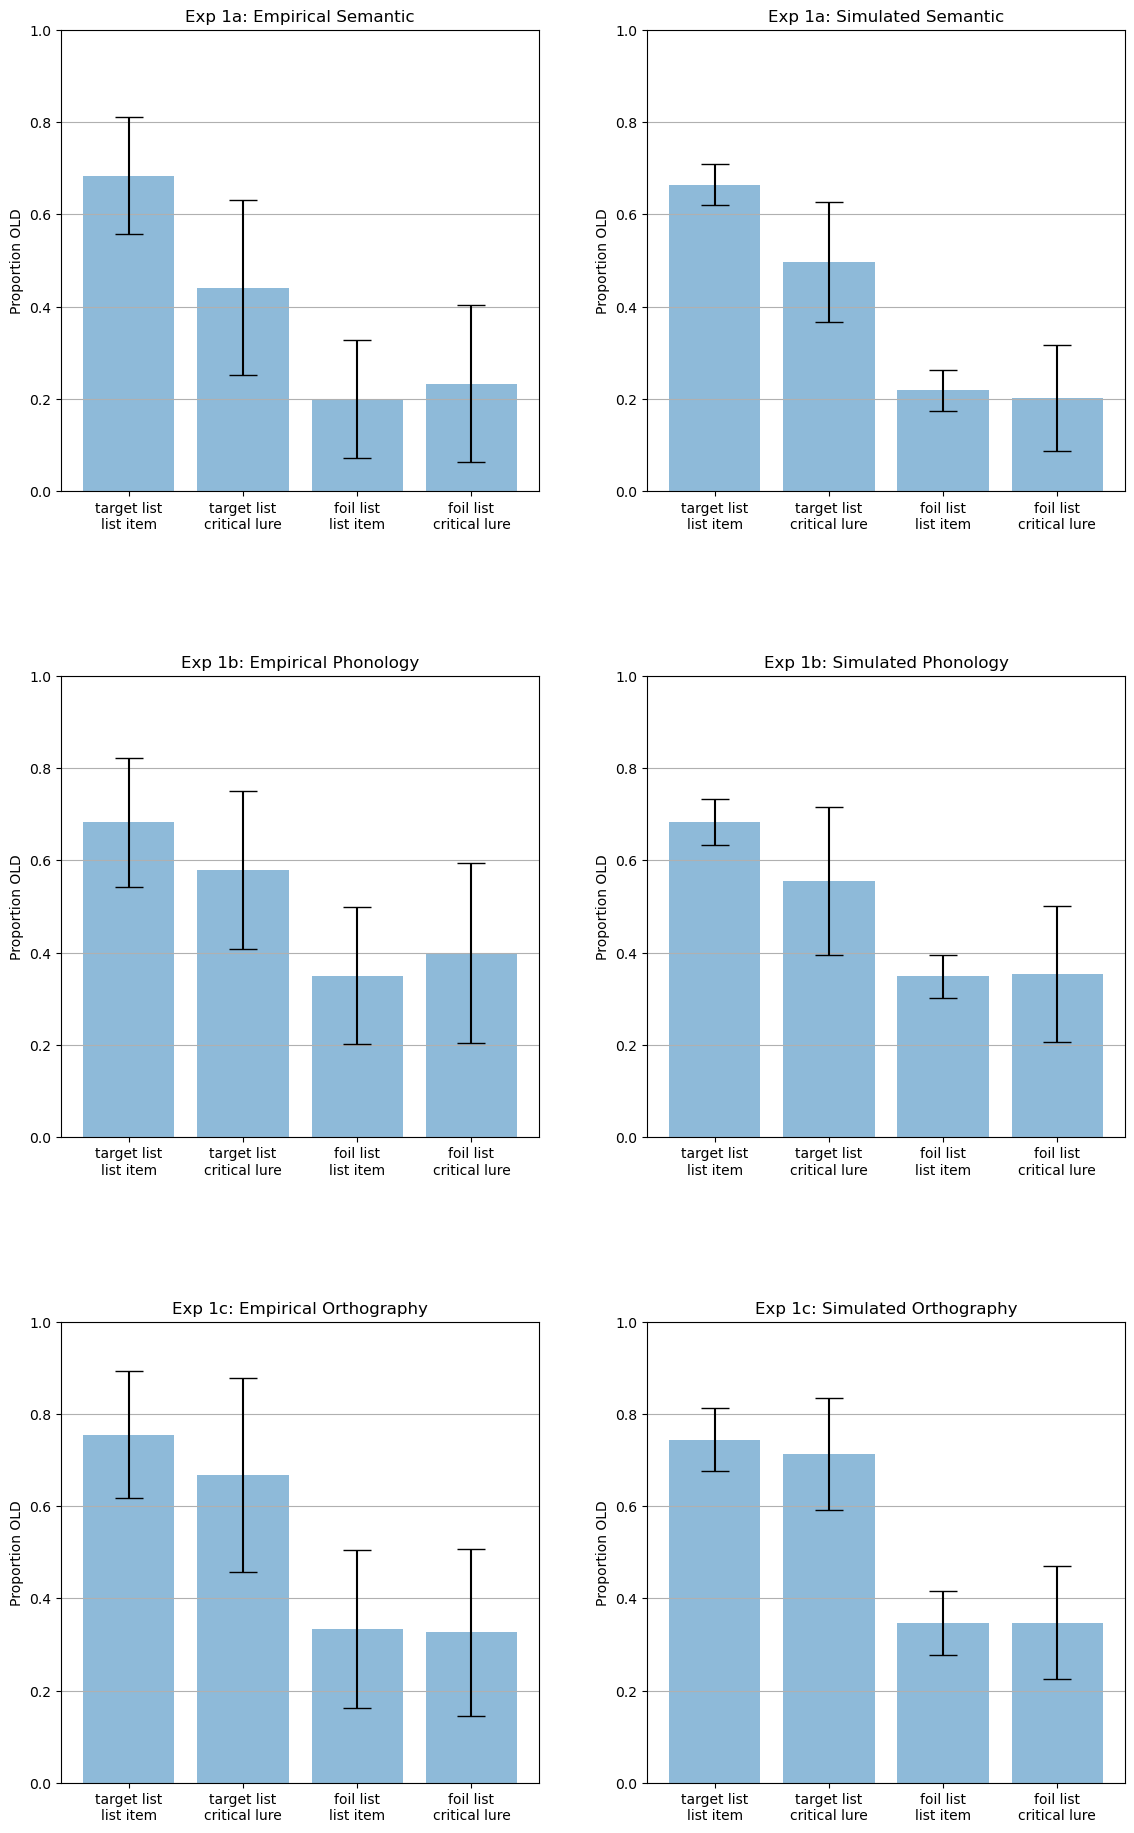

In [41]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout()

plt.setp(ax, ylim=(0, 1))

ax[0, 0].bar(x_pos, emp_sem_means,
       yerr=emp_sem_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[0, 0].set_ylabel('Proportion OLD')
ax[0, 0].set_xticks(x_pos)
ax[0, 0].set_xticklabels(labels)
ax[0, 0].set_title('Exp 1a: Empirical Semantic')
ax[0, 0].yaxis.grid(True)


ax[0, 1].bar(x_pos, sim_sem_means,
       yerr=sim_sem_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[0, 1].set_ylabel('Proportion OLD')
ax[0, 1].set_xticks(x_pos)
ax[0, 1].set_xticklabels(labels)
ax[0, 1].set_title('Exp 1a: Simulated Semantic')
ax[0, 1].yaxis.grid(True)


ax[1, 0].bar(x_pos, emp_phon_means,
       yerr=emp_phon_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[1, 0].set_ylabel('Proportion OLD')
ax[1, 0].set_xticks(x_pos)
ax[1, 0].set_xticklabels(labels)
ax[1, 0].set_title('Exp 1b: Empirical Phonology')
ax[1, 0].yaxis.grid(True)


ax[1, 1].bar(x_pos, sim_phon_means,
       yerr=sim_phon_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[1, 1].set_ylabel('Proportion OLD')
ax[1, 1].set_xticks(x_pos)
ax[1, 1].set_xticklabels(labels)
ax[1, 1].set_title('Exp 1b: Simulated Phonology')
ax[1, 1].yaxis.grid(True)

ax[2, 0].bar(x_pos, emp_ortho_means,
       yerr=emp_ortho_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[2, 0].set_ylabel('Proportion OLD')
ax[2, 0].set_xticks(x_pos)
ax[2, 0].set_xticklabels(labels)
ax[2, 0].set_title('Exp 1c: Empirical Orthography')
ax[2, 0].yaxis.grid(True)


ax[2, 1].bar(x_pos, sim_ortho_means,
       yerr=sim_ortho_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[2, 1].set_ylabel('Proportion OLD')
ax[2, 1].set_xticks(x_pos)
ax[2, 1].set_xticklabels(labels)
ax[2, 1].set_title('Exp 1c: Simulated Orthography')
ax[2, 1].yaxis.grid(True)

fig.set_size_inches(12, 20, forward=True)

R-squared fit overall:  0.9757435921930468


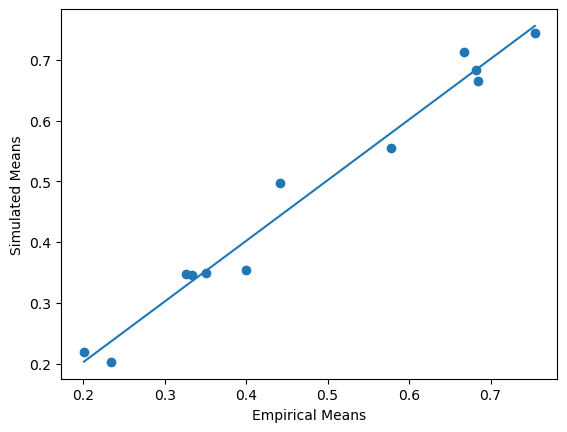

In [42]:
# Display scatterplot
print('R-squared fit overall: ', r_sq(exp_1_all_emp, exp_1_all_sim))
plt.scatter(exp_1_all_emp, exp_1_all_sim)
plt.plot(np.unique(exp_1_all_emp), np.poly1d(np.polyfit(exp_1_all_emp, exp_1_all_sim, 1))(np.unique(exp_1_all_emp)))
plt.xlabel("Empirical Means")
plt.ylabel("Simulated Means")
plt.show()

Simulation 2a -- Directed Forgetting with Semantic Lists

In [43]:
# Load stimuli
df = []
with open('Exp 2a -- Directed Forgetting Semantic Lists.csv', 'r') as f:
    for i in csv.reader(f):
        df.append(i)

In [44]:
# Set up stimuli into python lists
df_words = []
for i in df:
    df_words.append(i[1].split(', '))

In [45]:
# Remove spaces for two-word items (e.g., "root beer" -> "rootbeer")
def remove_spaces(x):
    return "".join([i for i in x if i!=' '])

In [46]:
# List of items to be substituted 
# Substitutes are for words not found in the Wikipedia corpus
subs = {'electric slide':'charleston'}

In [47]:
# Go through stimuli and replace missing words with substitutes
for i in range(0, len(df_words)):
    for x in range(0, len(df_words[i])):
        if df_words[i][x] not in word_dic:
            if remove_spaces(df_words[i][x]) not in word_dic:
                df_words[i][x] = subs[df_words[i][x]]
            else:
                df_words[i][x] = remove_spaces(df_words[i][x])

In [48]:
# Set up stimuli for counterbalance version A
stims_a = []
for i in df_words[:6]:
    stims_a.extend(i[:6])
for i in df_words[6:12]:
    stims_a.extend(i[:6])
for i in df_words[:6]:
    stims_a.extend(i[6:])
for i in df_words[6:12]:
    stims_a.extend(i[6:])
for i in df_words[12:24]:
    stims_a.extend(i[:3])

In [49]:
# Set up stimuli for counterbalance version B
stims_b = []
for i in df_words[6:12]:
    stims_b.extend(i[:6])
for i in df_words[:6]:
    stims_b.extend(i[:6])
for i in df_words[6:12]:
    stims_b.extend(i[6:])
for i in df_words[:6]:
    stims_b.extend(i[6:])
for i in df_words[12:24]:
    stims_b.extend(i[:3])

In [50]:
# Set up stimuli for counterbalance version C
stims_c = []
for i in df_words[12:18]:
    stims_c.extend(i[:6])
for i in df_words[18:]:
    stims_c.extend(i[:6])
for i in df_words[12:18]:
    stims_c.extend(i[6:])
for i in df_words[18:]:
    stims_c.extend(i[6:])
for i in df_words[:12]:
    stims_c.extend(i[:3])

In [51]:
# Set up stimuli for counterbalance version D
stims_d = []
for i in df_words[18:]:
    stims_d.extend(i[:6])
for i in df_words[12:18]:
    stims_d.extend(i[:6])
for i in df_words[18:]:
    stims_d.extend(i[6:])
for i in df_words[12:18]:
    stims_d.extend(i[6:])
for i in df_words[:12]:
    stims_d.extend(i[:3])

In [52]:
# Empirical means for Exp 2a (From Montagliani & Hockley, 2019, Canadian Journal of Experimental Psychology)
emp_means = np.array([.842, .62, .268, .193, .122])
emp_sds = np.array([0.024, 0.038, 0.035, 0.035, 0.023])*np.sqrt(26)

In [53]:
# Run simulations

r = 0.9   # learning rate for R-cued items
f = 0.6   # learning rate for F-cued items
t = 1       # Retrieval exponent
p_old = 45    # Percentage of items to be deemed old
sim_list = []
for s in range(0, 1000):
    if s < 250:
        stims = stims_a # simulations 0-250 with counterbalanced version A
    elif s < 500:
        stims = stims_b # simulations 250-500 with counterbalanced version B
    elif s < 750:
        stims = stims_c # simulations 500-750 with counterbalanced version C
    else:
        stims = stims_d # simulations 750-1000 with counterbalanced version C
    memory = make_memory(stims[0:72])
    memory[:36] *= np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-r, r]) # encoding for R-cued items -> based on R-cued learning rate
    memory[36:] *= np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-f, f]) # encoding for F-cued items -> based on F-cued learning rate
    probes = make_memory(stims)
    familiarities = echo_intensity(probes, memory, tau=t)
    criterion = np.percentile(familiarities, 100-p_old)
    r_hits = np.sum(familiarities[:36] > criterion) / 36 # calculate proportion of hits for R old items
    f_hits = np.sum(familiarities[36:72] > criterion) / 36 # calculate proportion of hits for F old items
    r_fa = np.sum(familiarities[72:90] > criterion) / 18 # calculate proportion of false alarms for R related items
    f_fa = np.sum(familiarities[90:108] > criterion) / 18 # calculate proportion of false alarms for F related items
    new_fa = np.sum(familiarities[108:144] > criterion) / 36 # calculate proportion of false alarms for Unrelated items
    sim_list.append([r_hits, f_hits, r_fa, f_fa, new_fa])
means = np.mean(sim_list, axis=0)
sds = np.std(sim_list, axis=0, ddof=1)
print('itemtype:', ['R old', 'F old', 'R related', 'F related', 'Unrelated'])
print('Empirical means: ', emp_means)
print('Simulated means: ', means)
print('Simulated SDs: ', sds)
print('R-squared fit: ', r_sq(emp_means, means))
print('mse_fit: ', mse(emp_means, means))

itemtype: ['R old', 'F old', 'R related', 'F related', 'Unrelated']
Empirical means:  [0.842 0.62  0.268 0.193 0.122]
Simulated means:  [0.80197222 0.60788889 0.35205556 0.27805556 0.06675   ]
Simulated SDs:  [0.06357166 0.0682032  0.07756678 0.06750518 0.02391685]
R-squared fit:  0.9538651722258106
mse_fit:  0.0038202496913582523


In [54]:
# Save simulated and empirical means for Exp 2a (for graphs later)
sem_sim = means.copy()
sem_emp = emp_means.copy()
sem_sim_sds = sds.copy()
sem_emp_sds = emp_sds.copy()

Simulation 2b -- Directed Forgetting with Phonological Lists

In [55]:
# Load stimuli
with open('Exp 2b -- Directed Forgetting Phonological Lists.csv', 'r') as f:
    df = []
    for i in csv.reader(f):
        df.append(i[0])

In [56]:
# set up stimuli into Python lists
p_lists = []
for i in df:
    linewords = i.split(', ')
    p_lists.append(linewords)

In [57]:
# Exp 2b uses randomized presentation rather than counterbalancing
# This is a function to randomize lists and items
def randomize_lists(lists):
    stims = lists.copy()
    random.shuffle(stims)
    r_old = []
    f_old = []
    r_new = []
    f_new = []
    new_new = []
    for i in stims[:6]:
        shuffled = i.copy()
        random.shuffle(shuffled)
        for x in shuffled[:6]:
            r_old.append(x)
        for x in shuffled[6:9]:
            r_new.append(x)
    for i in stims[6:12]:
        shuffled = i.copy()
        random.shuffle(shuffled)
        for x in shuffled[:6]:
            f_old.append(x)
        for x in shuffled[6:9]:
            f_new.append(x)
    for i in stims[12:]:
        shuffled = i.copy()
        random.shuffle(shuffled)
        for x in shuffled[:3]:
            new_new.append(x)
    return r_old + f_old + r_new + f_new + new_new

In [58]:
# Empirical means and SDs for Exp 2b
emp_means = np.array([0.68027211, 0.50226757, 0.41156463, 0.34807256, 0.28684807])
emp_sds = np.array([0.12540091, 0.20085631, 0.19899386, 0.21539737, 0.20494056])

In [59]:
# Run simulations

r = 0.02
f = 0.01
t = 1
p_old = 46

sim_list = []
for s in range(0, 1000):
    stims = randomize_lists(p_lists)
    memory = make_memory(stims[0:72])
    memory[:36] *= np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-r, r])
    memory[36:] *= np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-f, f])
    probes = make_memory(stims)
    familiarities = echo_intensity(probes, memory, tau=t)
    criterion = np.percentile(familiarities, 100-p_old)
    r_hits = np.sum(familiarities[:36] > criterion) / 36
    f_hits = np.sum(familiarities[36:72] > criterion) / 36
    r_fa = np.sum(familiarities[72:90] > criterion) / 18
    f_fa = np.sum(familiarities[90:108] > criterion) / 18
    new_fa = np.sum(familiarities[108:144] > criterion) / 36
    sim_list.append([r_hits, f_hits, r_fa, f_fa, new_fa])
means = np.mean(sim_list, axis=0)
sds = np.std(sim_list, axis=0, ddof=1)
print('itemtype:', ['R old', 'F old', 'R related', 'F related', 'Unrelated'])
print('Empirical means: ', emp_means)
print('Simulated means: ', means)
print('Simulated SDs: ', sds)
print('R-squared fit: ', r_sq(emp_means, means))
print('mse_fit: ', mse(emp_means, means))

itemtype: ['R old', 'F old', 'R related', 'F related', 'Unrelated']
Empirical means:  [0.68027211 0.50226757 0.41156463 0.34807256 0.28684807]
Simulated means:  [0.62863889 0.509      0.47888889 0.40422222 0.25413889]
Simulated SDs:  [0.0872802  0.08886831 0.12131441 0.11772423 0.07874809]
R-squared fit:  0.8841702697934776
mse_fit:  0.0022933092135162354


In [60]:
# Save empirical and simulated means and SDs for Exp 2b
phon_sim = means.copy()
phon_emp = emp_means.copy()
phon_sim_sds = sds.copy()
phon_emp_sds = emp_sds.copy()

Simulation 2c -- Directed Forgetting with Nonword Orthographic Lists

In [61]:
# load stimuli for Counterbalanced version A
test_a = []
with open('Exp 2c -- Directed Forgetting Nonword Orthographic Lists -- Version A.csv', 'r') as f:
    csvreader = csv.reader(f)
    for i in csvreader:
        test_a.append(i)

In [62]:
# load stimuli for Counterbalanced version B
test_b = []
with open('Exp 2c -- Directed Forgetting Nonword Orthographic Lists -- Version B.csv', 'r') as f:
    csvreader = csv.reader(f)
    for i in csvreader:
        test_b.append(i)

In [63]:
# load stimuli for Counterbalanced version C
test_c = []
with open('Exp 2c -- Directed Forgetting Nonword Orthographic Lists -- Version C.csv', 'r') as f:
    csvreader = csv.reader(f)
    for i in csvreader:
        test_c.append(i)

In [64]:
# load stimuli for Counterbalanced version D
test_d = []
with open('Exp 2c -- Directed Forgetting Nonword Orthographic Lists -- Version D.csv', 'r') as f:
    csvreader = csv.reader(f)
    for i in csvreader:
        test_d.append(i)

In [65]:
# function to set up stimuli list for running simulation
def get_stim_list(df):
    clean_df = df[1:]
    r_old = [i[1].lower() for i in clean_df if i[2]=='R' and i[4]=='old']
    f_old = [i[1].lower() for i in clean_df if i[2]=='F' and i[4]=='old']
    r_new = [i[1].lower() for i in clean_df if i[2]=='R' and i[4]=='new']
    f_new = [i[1].lower() for i in clean_df if i[2]=='F' and i[4]=='new']
    new_new = [i[1].lower() for i in clean_df if i[2]=='New' and i[4]=='new']
    return r_old + f_old + r_new + f_new + new_new

In [66]:
# Empirical Means and SDs (from Reid, Yang, and Jamieson, 2023, Exp 1, Memory & Cognition)
emp_means = np.array([0.72619048, 0.52947846, 0.61111111, 0.42630385, 0.16326531])
emp_sds = np.array([0.18530089, 0.25366451, 0.21960262, 0.24932722, 0.15514088])

In [67]:
# Run simulations

l = .06
f = .03
t = 1 
p_old = 48

sim_list = []
for s in range(0, 1000):
    if s <= 250:
        stims = get_stim_list(test_a)
    elif s <= 500:
        stims = get_stim_list(test_b)
    elif s <= 750:
        stims = get_stim_list(test_c)
    else:
        stims = get_stim_list(test_d)
    memory = make_memory(stims[0:72])
    memory[0:36] = memory[0:36] * np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-l, l])
    memory[36:72] = memory[36:72] * np.random.choice([0, 1], size=(36, len(memory[0])), p=[1-f, f])
    probes = make_memory(stims)
    familiarities = echo_intensity(probes, memory, tau=t)
    criterion = np.percentile(familiarities, 100-p_old)
    r_hits = np.sum(familiarities[:36] > criterion) / 36
    f_hits = np.sum(familiarities[36:72] > criterion) / 36
    r_fa = np.sum(familiarities[72:90] > criterion) / 18
    f_fa = np.sum(familiarities[90:108] > criterion) / 18
    new_fa = np.sum(familiarities[108:144] > criterion) / 36
    sim_list.append([r_hits, f_hits, r_fa, f_fa, new_fa])
means = np.mean(sim_list, axis=0)
sds = np.std(sim_list, axis=0, ddof=1)
print('itemtype:', ['R old', 'F old', 'R related', 'F related', 'Unrelated'])
print('Empirical means: ', emp_means)
print('Simulated means: ', means)
print('Simulated SDs: ', sds)
print('R-squared fit: ', r_sq(emp_means, means))
print('mse_fit: ', mse(emp_means, means))

itemtype: ['R old', 'F old', 'R related', 'F related', 'Unrelated']
Empirical means:  [0.72619048 0.52947846 0.61111111 0.42630385 0.16326531]
Simulated means:  [0.7105     0.51227778 0.64433333 0.45622222 0.14361111]
Simulated SDs:  [0.10899128 0.11823272 0.12897729 0.12812001 0.07196435]
R-squared fit:  0.9855110765719806
mse_fit:  0.0005854334570283015


In [68]:
# save empirical and simulated means and SDs for Exp 2c
ortho_sim = means.copy()
ortho_emp = emp_means.copy()
ortho_sim_sds = sds.copy()
ortho_emp_sds = emp_sds.copy()

Calculate fits across Experiment 2

In [69]:
all_sim = np.concatenate((sem_sim, phon_sim, ortho_sim)) # create vector with all empirical means from Exp 2a-c
all_emp = np.concatenate((sem_emp, phon_emp, ortho_emp)) # create vector with all simulated means from Exp 2a-c

In [70]:
### Calculate R-squared fit
print('R-squared fit: ', r_sq(all_sim, all_emp))

R-squared fit:  0.952220819001258


In [71]:
### Calculate Mean Squared Error fit
print('Mean Squared Error fit: ', mse(all_sim, all_emp))

Mean Squared Error fit:  0.002232997453967596


Display Graphs for Exp 2

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
labels = ['R old', 'F old', 'R related', 'F related', 'Unrelated']
x_pos = np.arange(len(labels))

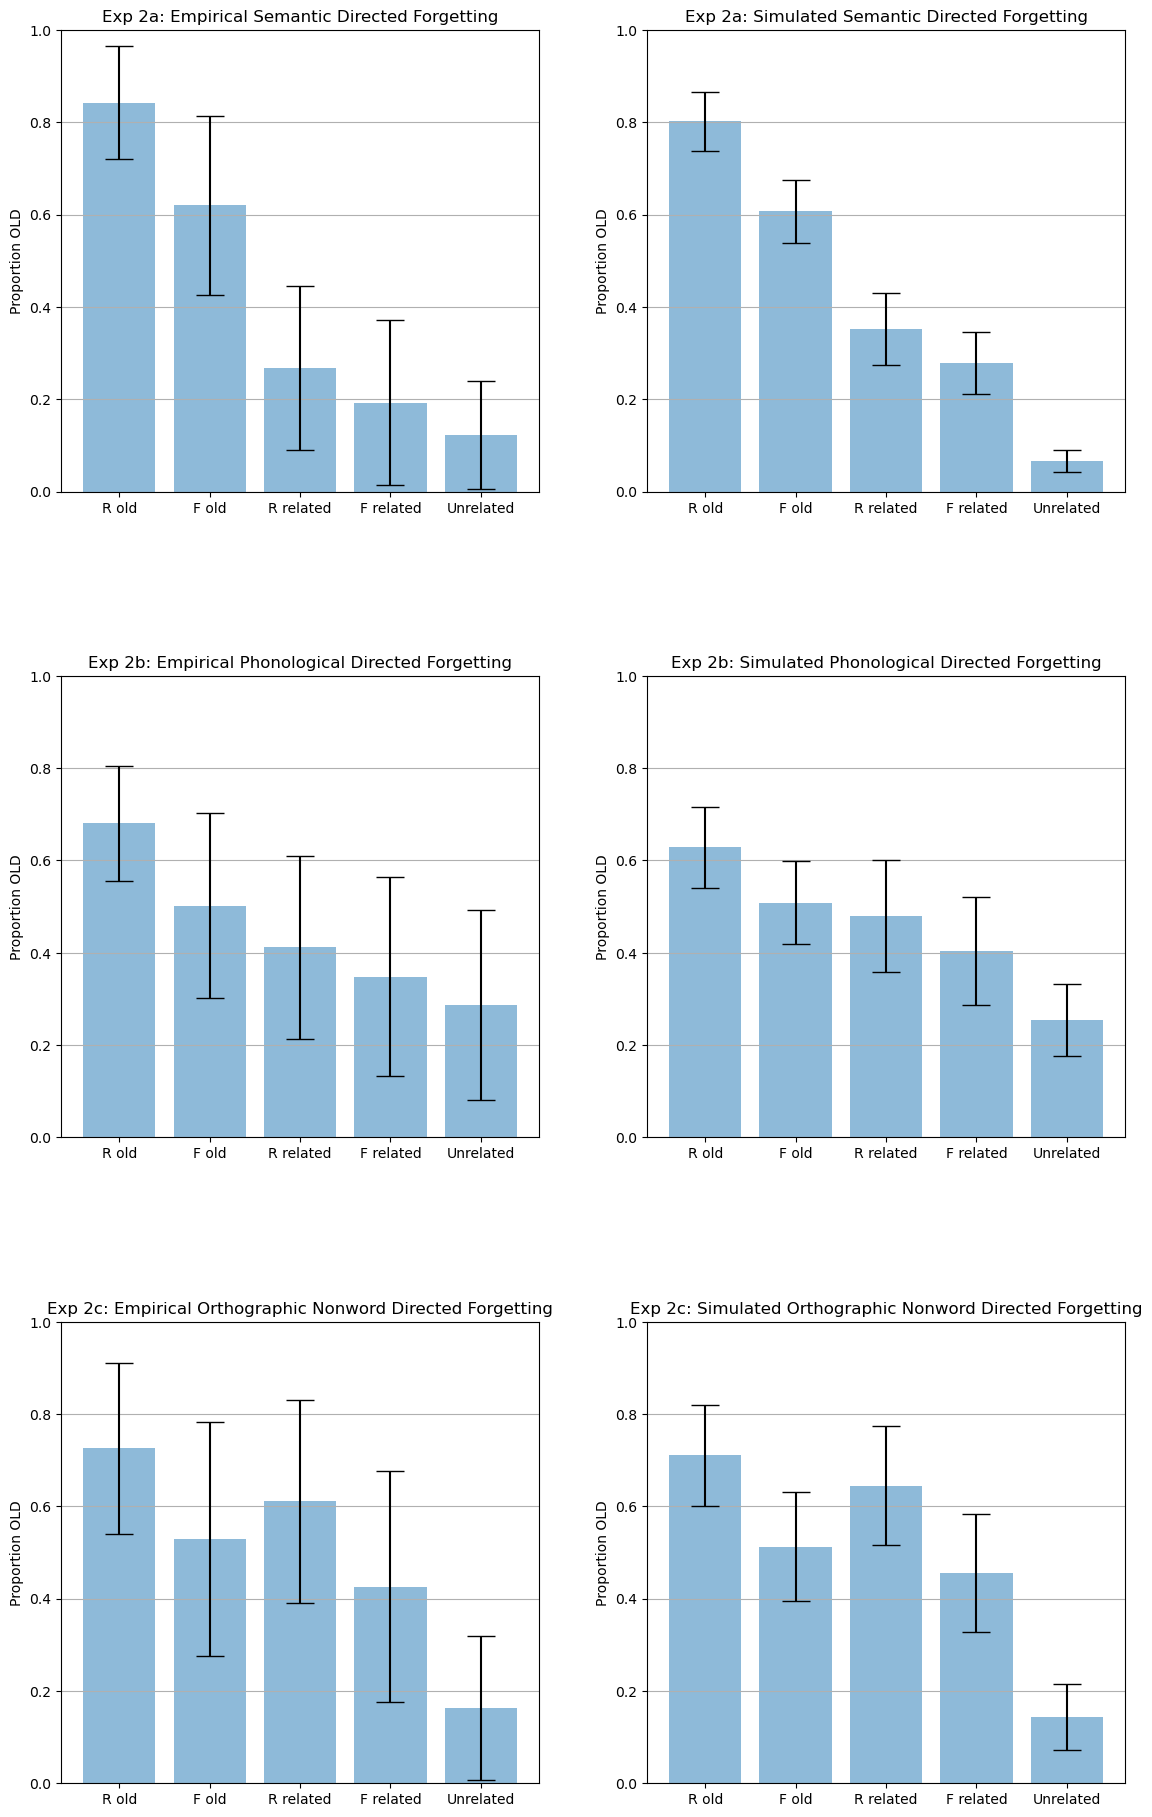

In [74]:
fig, ax = plt.subplots(3, 2)
fig.tight_layout()

plt.setp(ax, ylim=(0, 1))

ax[0, 0].bar(x_pos, sem_emp,
       yerr=sem_emp_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[0, 0].set_ylabel('Proportion OLD')
ax[0, 0].set_xticks(x_pos)
ax[0, 0].set_xticklabels(labels)
ax[0, 0].set_title('Exp 2a: Empirical Semantic Directed Forgetting')
ax[0, 0].yaxis.grid(True)


ax[0, 1].bar(x_pos, sem_sim,
       yerr=sem_sim_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[0, 1].set_ylabel('Proportion OLD')
ax[0, 1].set_xticks(x_pos)
ax[0, 1].set_xticklabels(labels)
ax[0, 1].set_title('Exp 2a: Simulated Semantic Directed Forgetting')
ax[0, 1].yaxis.grid(True)


ax[1, 0].bar(x_pos, phon_emp,
       yerr=phon_emp_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[1, 0].set_ylabel('Proportion OLD')
ax[1, 0].set_xticks(x_pos)
ax[1, 0].set_xticklabels(labels)
ax[1, 0].set_title('Exp 2b: Empirical Phonological Directed Forgetting')
ax[1, 0].yaxis.grid(True)


ax[1, 1].bar(x_pos, phon_sim,
       yerr=phon_sim_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[1, 1].set_ylabel('Proportion OLD')
ax[1, 1].set_xticks(x_pos)
ax[1, 1].set_xticklabels(labels)
ax[1, 1].set_title('Exp 2b: Simulated Phonological Directed Forgetting')
ax[1, 1].yaxis.grid(True)

ax[2, 0].bar(x_pos, ortho_emp,
       yerr=ortho_emp_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[2, 0].set_ylabel('Proportion OLD')
ax[2, 0].set_xticks(x_pos)
ax[2, 0].set_xticklabels(labels)
ax[2, 0].set_title('Exp 2c: Empirical Orthographic Nonword Directed Forgetting')
ax[2, 0].yaxis.grid(True)


ax[2, 1].bar(x_pos, ortho_sim,
       yerr=ortho_sim_sds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax[2, 1].set_ylabel('Proportion OLD')
ax[2, 1].set_xticks(x_pos)
ax[2, 1].set_xticklabels(labels)
ax[2, 1].set_title('Exp 2c: Simulated Orthographic Nonword Directed Forgetting')
ax[2, 1].yaxis.grid(True)

fig.set_size_inches(12, 20, forward=True)

R-squared fit overall:  0.952220819001258


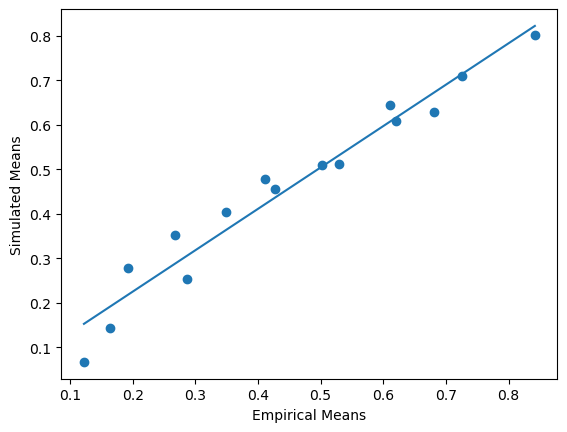

In [75]:
# Display scatterplot
print('R-squared fit overall: ', r_sq(all_emp, all_sim))
plt.scatter(all_emp, all_sim)
plt.plot(np.unique(all_emp), np.poly1d(np.polyfit(all_emp, all_sim, 1))(np.unique(all_emp)))
plt.xlabel("Empirical Means")
plt.ylabel("Simulated Means")
plt.show()